# Neural Radiance Fields
---
Luc Frachon


## Imports

In [1]:
import sys, os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as td
import torchvision as tv
import PIL
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(edgeitems=30, linewidth=100, formatter=dict(float=lambda x: "%.3f" % x))

## Configuration

In [248]:
# from collections import OrderedDict

DATA_CONFIG = OrderedDict(
    np_data_filepath = "./data/tiny_nerf_data.npz", 
    height = 100,
    width = 100,
    n_samples_per_ray = 64,
    near_bound = 2.,
    far_bound = 6.,
    fine_sample_multiplicator = 2.,
    test_img_idx = 101,
    random_state = 42,
    precision = torch.float16,
)
MODULE_CONFIG = OrderedDict(
    coord_dims = 10,
    direction_dims = 4,
    normalize_position = False,
    n_layers = 8,
    skip_at_layer = 5,
    layer_dim = 256,
    use_fine_samples = True,
    num_workers = 0,
    learning_rate = 1e-4,
    batch_size = 2048,
    noise_std = 0.03,
    normalize_directions = True,
)
RUN_CONFIG = OrderedDict(
    logging = True,
    run_name = "MiniNeRF_coarse_float16_model_v2",
    run_notes = "Half-precision, normal sampling density",
    early_stopping = True,
    early_stop_delta = 1e-4,
    early_stop_patience = 1_050_000 / MODULE_CONFIG['batch_size'] * 5,  # 5 epochs
    max_epochs = 500,
    gradient_clip_val = 5.,
    log_every_n_steps = 20,
)

## Look at the data

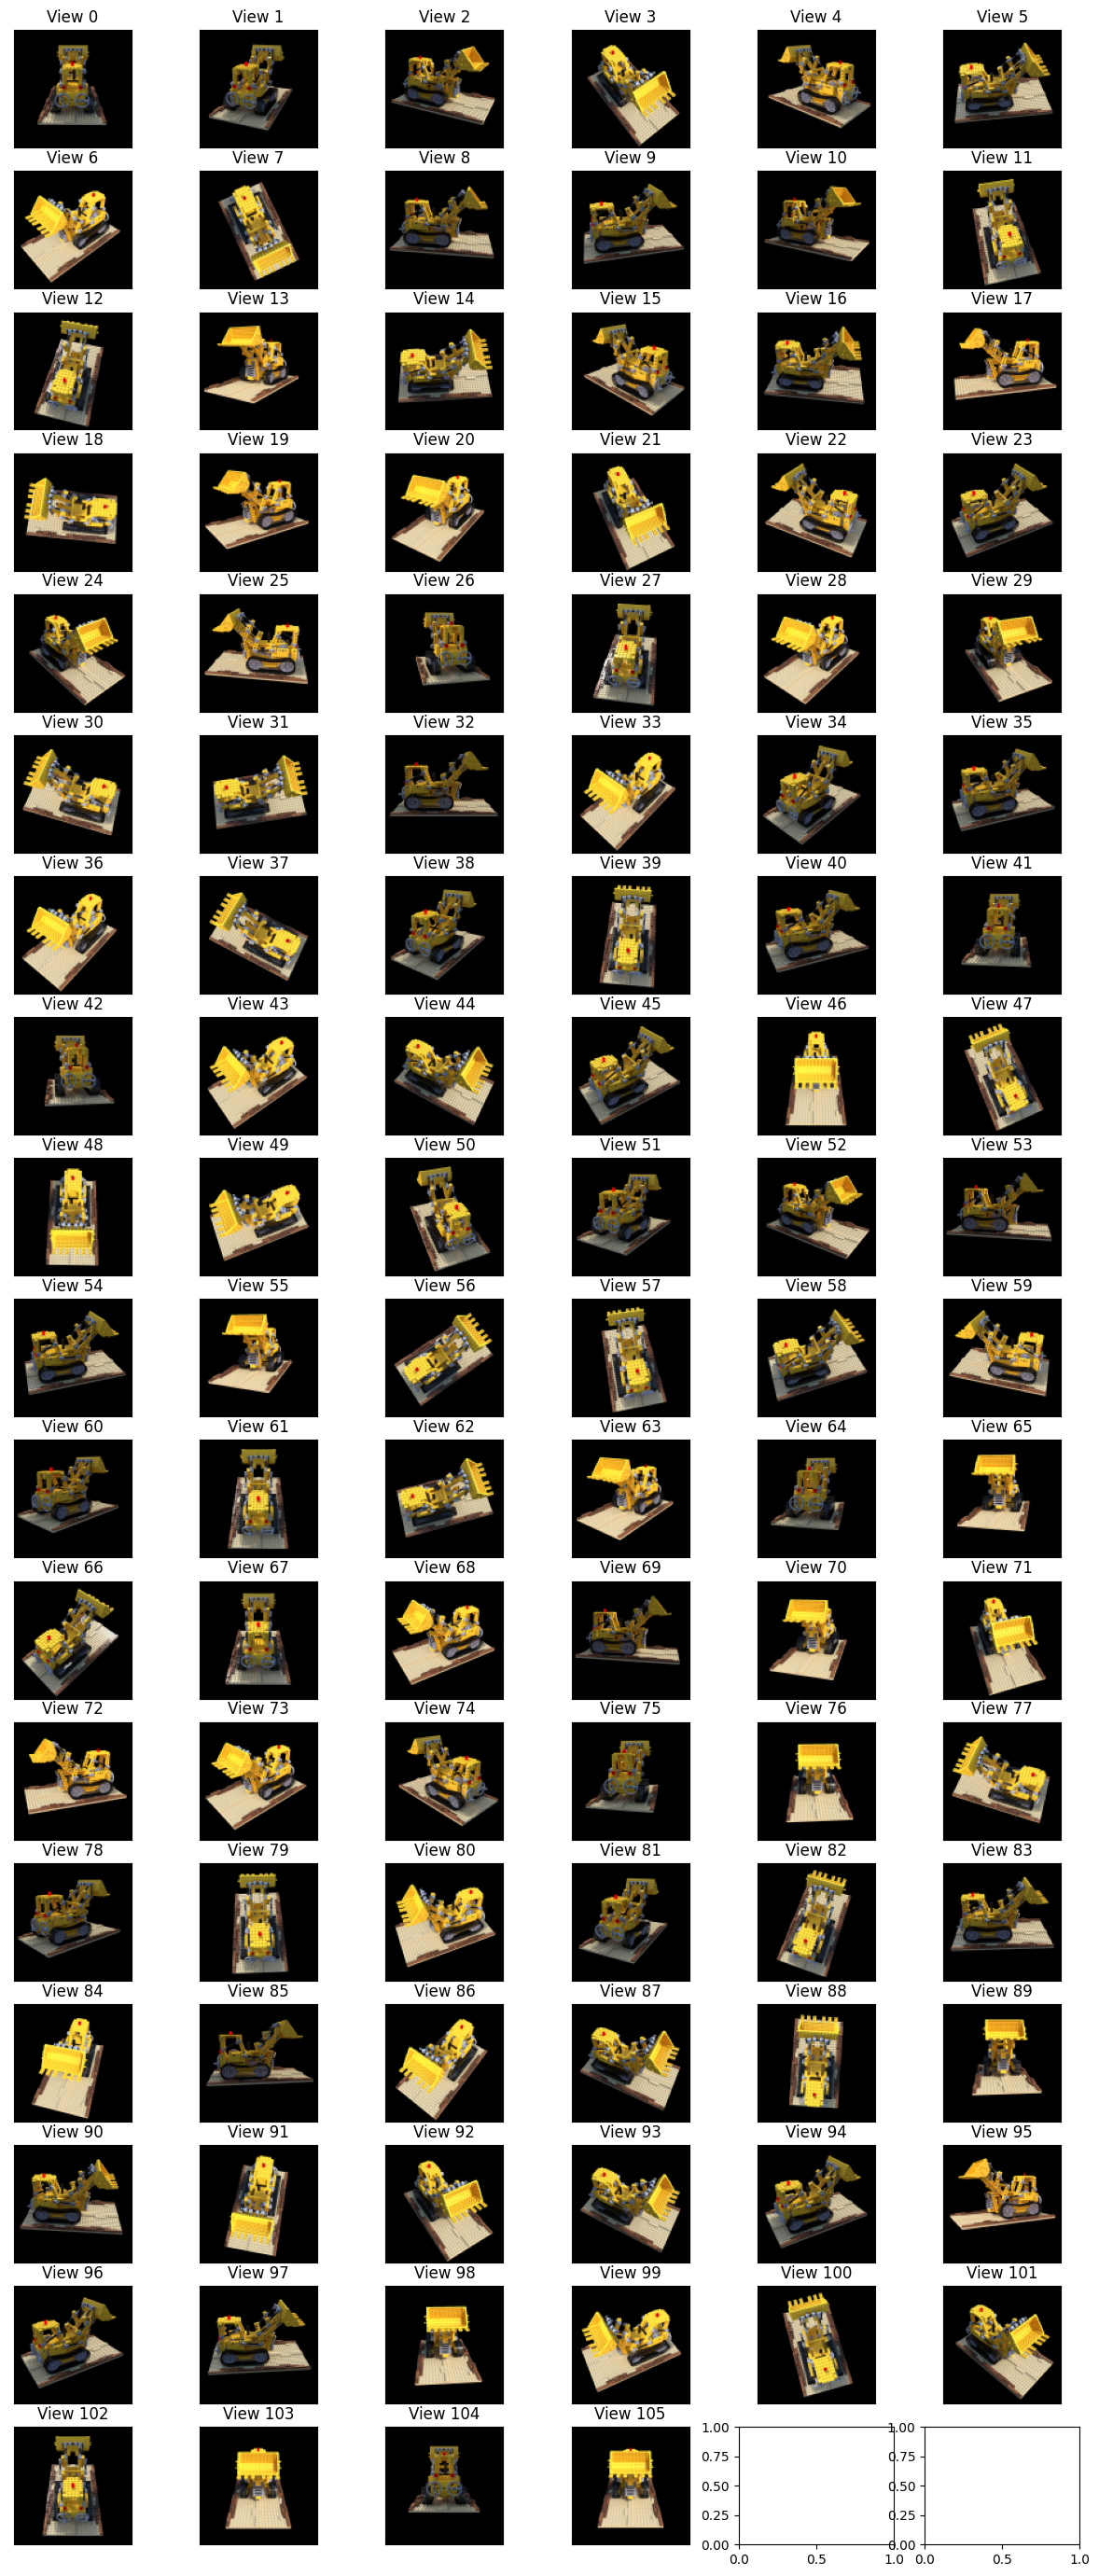

In [3]:
data = np.load(DATA_CONFIG['np_data_filepath'])

f, axes = plt.subplots(nrows=18, ncols=6, figsize=(15, 35))
for i in range(len(data['poses'])):
    ax = axes[i // 6, i % 6]
    ax.imshow(data['images'][i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"View {i}");

In [4]:
data['poses'].shape, data['focal']

((106, 4, 4), array(138.889))

## Extracting rays from the image dataset

In [5]:
def get_rays_from_image(width: int, height: int, focal: float, pose_matrix: torch.Tensor):
    """
    The rays are oriented from the scene towards the camera. The coordinates of the
    ray's unit vectors use x towards the RHS of the image, y towards the top, 
    and z towards the focal point.
   
   pose_matrix: A (n_image, 4, 4) tensor containing the pose angles and translation vector for the
      camera position for all images.
   
   :return: 
    origin_world_coords: The camera position (all rays' origin) as a 3D vector expressed in the 
    world coordinate system, expanded into a (height, width, 3) tensor.
    dir_world_coors: The directions of each ray (pixel), as unit vectors, in a tensor of
    dimensions (height, width, 3).
    """
    
    # Create 2 meshgrids with coordinates centred around the image's centre.
    if isinstance(focal, np.ndarray):
        focal = focal.item()
    
    rotation = pose_matrix[..., :3, :3]
    camera_pos = pose_matrix[..., :3, -1]

    if not isinstance(rotation, torch.Tensor):
        rotation = torch.tensor(rotation, dtype=torch.float32)
    if not isinstance(camera_pos, torch.Tensor):
        camera_pos = torch.tensor(camera_pos, dtype=torch.float32)
        
    n_img = rotation.size(0)
    xs, ys = torch.meshgrid(
        torch.arange(width, dtype=torch.float32), 
        torch.arange(height, dtype=torch.float32),
        indexing='xy'
    )
    xs, ys = xs - width / 2., ys - height / 2.  # centre around 0
 
    dir_cam_coords = torch.stack([
        xs, 
        -ys,  # in the meshgrid, y points toward the bottom of the picture
        -torch.zeros_like(xs).fill_(focal)
    ], dim=-1)
    dir_cam_coords /= focal
    
    dir_cam_coords = dir_cam_coords.reshape((-1, 3))  # reshape before the matmul
    dir_world_coords = torch.matmul(
        dir_cam_coords,
        rotation.transpose(-1, -2),
    ).to(DATA_CONFIG['precision']).reshape((n_img * height * width, 1, 3))
        
    origins = camera_pos.to(
        DATA_CONFIG['precision']
    ).unsqueeze(-1).transpose(-1, -2)
    origins = origins.repeat_interleave(
        height * width,
        dim=0,
        output_size=n_img * height * width
    )
    
    return origins, dir_world_coords

The plot below shows the position and ray directions for all images in the data.

(106, 100, 100, 3)


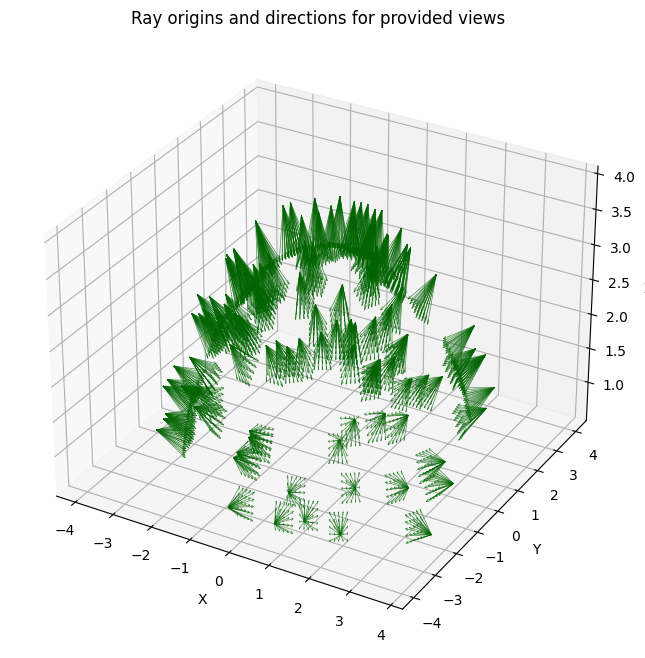

In [6]:
# %matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

n_views = 106
origins, dirs = get_rays_from_image(100, 100, data['focal'].item(), data['poses'][:n_views])
orig_resh = origins.reshape(n_views, 100, 100, -1).numpy()
dirs_resh = dirs.reshape(n_views, 100, 100, -1).numpy()
bin_sz_x, bin_sz_y = 20, 20
        
dirs_binned = np.mean(dirs_resh.reshape(n_views, 100//bin_sz_y, bin_sz_y, 100//bin_sz_x, bin_sz_x, dirs_resh.shape[-1]), axis=(2, 4))
orig_binned = np.mean(orig_resh.reshape(n_views, 100//bin_sz_y, bin_sz_y, 100//bin_sz_x, bin_sz_x, orig_resh.shape[-1]), axis=(2, 4))

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111, projection='3d')

x, y, z = orig_binned[ ..., 0], orig_binned[ ..., 1], orig_binned[ ..., 2]
u, v, w = dirs_binned[ ..., 0], dirs_binned[ ..., 1], dirs_binned[ ..., 2]

ax.quiver(x, y, z, u, v, w, length=0.7, arrow_length_ratio=0.1, linewidths=0.5, color="darkgreen", alpha=.7)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("Ray origins and directions for provided views")
plt.show();

## Sampling points along rays

In [7]:
def get_samples_from_rays(
    origins, directions, near_bound, far_bound, n_coarse, noisy = True, distribution = None, fine_sample_multiplicator = None
):
    """
    Given a batch of ray origins and directions, 2 behaviours are possible: 
    - If distribution is None: Divide the distance between far_bound and near_bound by n_samples to 
    create n_samples intervals, then sample uniformly at random from each interval.
    - If distribution is not None but is passed as a PDF, sample `n_samples * fine_sample_multiplicator` 
    points from this distribution. 
    
    `origins`: Tensor of shape (n_img * h * w, 1, 3). Coordinates of the origin of each ray in the batch (focal 
        point of their respective camera). Note that during inference, all the rays are from the same image,
        therefore  the (x, y, z) coordinates are the same for all rays.
    `directions`: Tensor of shape (n_img * h * w, 1, 3). Coordinates of the unit vector that defines each ray in the batch.
    `distribution`: When performing fine sampling, this is the distribution to use. If None, uses the noisy uniform distribution 
        by bin.
    `fine_sample_multiplicator`: Set to None to only perform coarse sampling.
        
    :return: 
    sample_coords: The coordinates and directions of each sampled point, as a (n_img * h * w, n_samples, 6) tensor.
    sample_distances: The distance values of each sampled point along its ray, as a (n_img * h * w, n_samples, 1) tensor.
    """
    bin_centres_c = torch.linspace(near_bound, far_bound, steps=n_coarse).to(origins.device)
    if noisy:
        noise = torch.rand((origins.shape[0], n_coarse, 1), dtype=origins.dtype).to(origins.device)
        noise *= (far_bound - near_bound) / n_coarse
    else:
        noise = torch.zeros((origins.shape[0], n_coarse, 1), dtype=origins.dtype).to(origins.device)
        
    coarse_distances = bin_centres_c[None, :, None] + noise
    
    # # Ensure we remain within the bounds. .clamp is not implemented for float16 so we do it manually :-)
    # coarse_distances = torch.min(
    #     torch.max(coarse_distances, torch.zeros_like(coarse_distances).fill_(near_bound)), 
    #     torch.zeros_like(coarse_distances).fill_(far_bound)
    # )
    
    if fine_sample_multiplicator is not None:
        n_fine = int(n_coarse * fine_sample_multiplicator)
        if distribution is not None:
            fine_distances = distribution.sample(n_fine).to(origins.device)
        else:
            bin_centres_f = torch.linspace(near_bound, far_bound, steps=n_fine).to(origins.device)
            noise = torch.rand((origins.shape[0], n_fine, 1), dtype=origins.dtype).to(origins.device)
            noise *= (far_bound - near_bound) / n_fine
            fine_distances = bin_centres_f[None, :, None] + noise
            # Ensure we remain within the bounds. .clamp is not implemented for float16 so we do it manually :-)
            fine_distances = torch.min(
                torch.max(fine_distances, torch.zeros_like(fine_distances).fill_(near_bound)),
                torch.zeros_like(fine_distances).fill_(far_bound)
            )

        n_samples = n_fine + n_coarse
        sample_distances = torch.concat([coarse_distances, fine_distances], dim=1)
    else:
        n_samples = n_coarse
        sample_distances = coarse_distances

    # samples_distances = torch.sort(sample_distances, dim=1)
    sample_coords = origins + directions * sample_distances
    # Add coordinates of the unit vector for corresponding ray:
    directions = directions.expand(-1, n_samples, -1)
    
    return sample_coords, directions, sample_distances

This plot shows the rays corresponding to the first 10,000 pixels, i.e. the first image.

### Some convenience functions for plotting in 3D

In [8]:
def to_numpy_unflatten(values: torch.Tensor, height: int, width: int):
    assert values.size(0) == height * width, values.numel()
    return values.reshape(height, width, -1, values.shape[2]).detach().cpu().numpy()

def bin_dims(values: np.ndarray, bin_sz_x: int, bin_sz_y: int, bin_sz_z: int):
    sz_x, sz_y, sz_z, _ = values.shape
    return np.mean(
        values.reshape(
            sz_x//bin_sz_x, 
            bin_sz_x,
            sz_y//bin_sz_y,
            bin_sz_y,
            sz_z//bin_sz_z,
            bin_sz_z,
            -1
        ),
        axis=(1, 3, 5)
    ).squeeze()

def scatter_densities_3d(values, fig_kwargs={}, scatter_kwargs={}):
    # Make a 3D plot of densities
    fig = plt.figure(**fig_kwargs)
    ax = fig.add_subplot(111, projection='3d')
    x, y, z = np.meshgrid(range(values.shape[0]), range(values.shape[1]), range(values.shape[2]))
    # Define the color of each voxel based on the tensor values
    colors = np.ravel(values)
    # Create the voxel plot
    ax.scatter(x, y, z, c=colors, cmap='coolwarm', **scatter_kwargs)
    # Add axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show();
    
def scatter_points_3d(values, fig_kwargs={}, scatter_kwargs={}):
    # Make a 3D plot of densities
    fig = plt.figure(**fig_kwargs)
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(values[..., 0], values[..., 1], values[..., 2], **scatter_kwargs)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show();    
    
def quiver3d(values, fig_kwargs={}, arrow_kwargs={}):
    fig = plt.figure(**fig_kwargs)
    ax = fig.add_subplot(111, projection='3d')
    xs, ys, zs = values[..., 0], values[..., 1], values[..., 2]
    us, vs, ws = values[..., 3], values[..., 4], values[..., 5]
    ax.quiver(xs, ys, zs, us, vs, ws, **arrow_kwargs)
    # Add axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show();

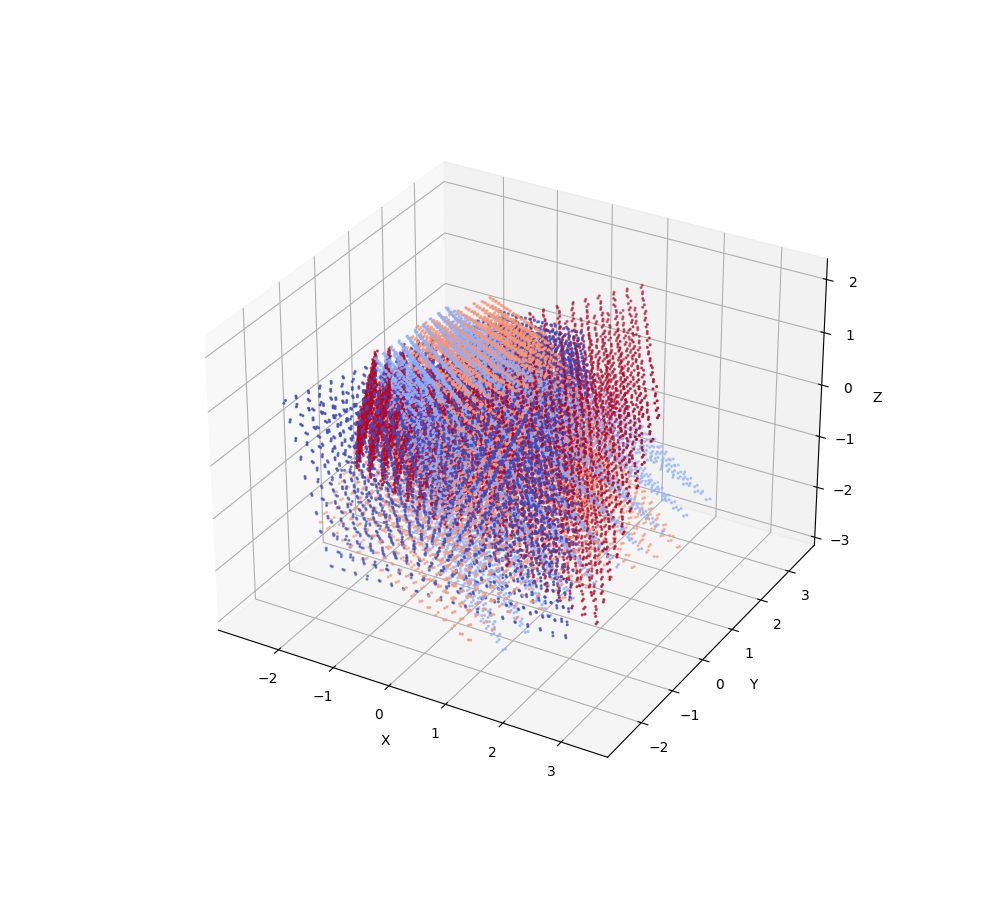

(-5.0, 5.0)

In [30]:
%matplotlib widget
n_samples = 20
origins, directions = get_rays_from_image(100, 100, data['focal'].item(), data['poses'])
coords_all, dirs_all, dist_all = get_samples_from_rays(
    origins, directions, DATA_CONFIG['near_bound'], DATA_CONFIG['far_bound'], n_samples, noisy=True, fine_sample_multiplicator=None
)
coords_all = coords_all.cpu()
coords_all = torch.concat([coords_all, dirs_all], dim=-1)
coords_np = to_numpy_unflatten(coords_all[np.r_[0:10000, 30000:40000, 70000:80000, 100000:110000]], 200, 200)  # 4 images
coords_np = bin_dims(coords_np, 5, 5, 1)  # bin to speed up visualisation
colours = [0] * 400 * n_samples + [1] * 400 * n_samples + [3] * 400 * n_samples + [4] * 400 * n_samples

# quiver3d(
#     coords_np,
#     fig_kwargs={'figsize': (10, 9)},
#     arrow_kwargs={
#         'length': 0.7,
#         'normalize': False,
#         'arrow_length_ratio': 0.05,
#         'alpha': 1,
#         'linewidth': 0.5,
#     }
# )

scatter_points_3d(
    coords_np, 
    fig_kwargs={'figsize': (10, 9)}, 
    scatter_kwargs={'c': colours, 'cmap': 'coolwarm', 's': 1.5})
plt.xlim(-5, 5)
plt.ylim(-5, 5)

## Implement the rendering equation
(see blog post for explanations)

In [171]:
def render_image_colours(sample_distances, directions, densities, colours, noise_std = 0., normalize_directions = True):
    """
    Uses the rendering formula to compute the resulting colour at every position of the image.
    sample_distances: (BS, n_samples, 1)
    directions: (BS, n_samples, 3) Ray direction vector coordinates.
    densities: (BS, n_samples, 1) Density tensor. Contains one value for each sampling point of each 
        ray in the image. These values can be provided by the NeRF model and are always positive.
    colours: (BS, n_samples, 3) Colour tensor. Contains 3 values (R, G, B) for each sampling point
        of each ray in the image. These values can be provided by the NeRF model and are bounded 
        between 0 and 1.
        
    :return:
    colours: (BS, 3) Rendered (R, G, B) values for each pixel
    weights: (BS, n_samples, 1) The factor associated with that point of the ray, 
        used to weight the emitted colour at that point in that direction. Can be re-used to
        perform fine sampling.
    """
    last_pos_distance = 1e-10 + torch.zeros_like(sample_distances[..., [-1], :])
    distance_to_next = sample_distances[..., 1:, :] - sample_distances[..., :-1, :]
    distance_to_next = torch.concat([distance_to_next, last_pos_distance], dim=-2)
    if normalize_directions:
        distance_to_next = distance_to_next * torch.norm(directions, dim=-2, keepdim=True)
    noise = 0. if noise_std == 0. else torch.randn(densities.shape).to(densities) * noise_std
    sigma_delta = distance_to_next * (densities + noise)
    alpha = 1. - torch.exp(-sigma_delta)
    
    # Shifted 1 - alpha:
    one_minus_alpha_shifted = torch.concat(
        [torch.ones_like(sigma_delta[..., [0], :]), 1 - alpha[..., :-1, :] + 1e-10], 
        dim=-2
    )
    weights = alpha * torch.cumprod(one_minus_alpha_shifted, dim=-2)
    rendered_colours = torch.sum(weights * colours, dim=-2)

    return rendered_colours, weights

In [12]:
# Test all these functions with dummy model outputs
origins, directions = get_rays_from_image(100, 100, data['focal'], data['poses'])
points_dirs, directions, distances = get_samples_from_rays(origins, directions, 2., 6., 16, True, None, None)
densities = torch.relu(torch.randn((directions.shape[0], directions.shape[1], 1)))  # dummy
colours = torch.sigmoid(torch.randn((directions.shape[0], directions.shape[1], 3)))  # dummy
rgb, weights = render_image_colours(distances, directions, densities, colours, noise_std=0.)
print(rgb.shape, weights.shape)
print(rgb.amin(dim=(0,1)), rgb.amax(dim=(0,1)))
print(weights.min(), weights.max())

torch.Size([1060000, 3]) torch.Size([1060000, 16, 3])
tensor(0.) tensor(0.9749)
tensor(0.) tensor(0.9998)


In [13]:
def shift_dims(x, shift):
    """
    Like permute, changes the sequence of dimensions in a tensor. Unlike permute, it can only
    shift dimensions cyclically towards the right if `shift` > 0 or the left if `shift` < 0.
    The other difference (and the benefit) is that where permute can only handle a fixed number 
    of predefined dimensions, this function works with any number.
    """
    dims = torch.arange(x.dim())
    new_dims = dims.roll(shifts=shift)
    return x.permute(*new_dims)

## Distribution used for fine sampling


In [14]:
class PiecewiseConstant(td.Distribution):
    def __init__(self, pdf, bin_centres, far_bound, validate_args=None):
        self._pdf = pdf  .to(torch.float32)
        self._support = bin_centres.to(torch.float32)
        self.intervals = torch.concat(
            [bin_centres[..., 1:, :], torch.zeros_like(bin_centres[..., [0], :]).fill_(far_bound)],
            dim=1,
        ) - bin_centres
        self._cdf = torch.cumsum(pdf, dim=-2)
        super().__init__(torch.empty(0), validate_args=validate_args)

    def log_prob(self, x):
        raise NotImplementedError

    def sample(self, n_samples = 1):
        # Generate samples from a uniform distribution:
        uniform = td.Uniform(self._support[..., 0, :], self._support[..., -1, :])
        uni_samples = uniform.sample((n_samples,))
        
        # Map the samples to the piecewise constant distribution. Since searchsorted operates only on the last dimension,
        # we need to perform some permutations.
        cdf_indices = torch.searchsorted(
            self._cdf.transpose(-1, -2).contiguous(),
            shift_dims(uniform.cdf(uni_samples), -1).contiguous(),
            side='right'
        )
        cdf_indices = cdf_indices.transpose(-1, -2).clamp(0, self._support.size(-2) - 1)

        # From cdf_samples, we derive the sampling frequency within each constant piece of the PDF.
        # Within each piece, we sample uniformly
        noise = torch.rand_like(shift_dims(uni_samples, -1).transpose(-1, -2))
        final_samples = torch.gather(self._support, index=cdf_indices, dim=-2) 
        # final_samples, _ = torch.sort(final_samples, dim=-2)
        final_samples += noise * torch.gather(self.intervals, index=cdf_indices, dim=-2)
        return final_samples.to(DATA_CONFIG['precision'])
        
    @property
    def support(self):
        return self._support
    
    @property
    def pdf(self):
        return self._pdf

    @property
    def cdf(self):
        return self._cdf
    
    def update_pdf(self, new_pdf):
        self._pdf = new_pdf
        self._cdf = torch.cumsum(pdf, dim=-2)

## Data Loading and Serving

In [15]:
class RayDataProvider:
    def __init__(
        self, 
        np_data_filepath = "./data/tiny_nerf_data.npz", 
        np_data = None,
        n_samples_per_ray = 64,
        near_bound = 2.,
        far_bound = 6.,
        initial_distribution = None,
        fine_sample_multiplicator = None,
        test_img_idx: int = None,
        random_state = 0,
    ):
        """
        np_data_filepath: str; Path to a Numpy data file (.npz) containing the scene's images,
            poses, focal length, and other metadata.
        test_img_idx: int or None; Index of image and pose to use as a test example. Set to None
            for a randomly chosen image.
        """
        if np_data is None:
            data = np.load(np_data_filepath)
        else: 
            data = np_data
            
        test_img_idx = np.random.randint(0, len(data['images'])) if test_img_idx is None else test_img_idx
        self.test_idx = test_img_idx
               
        self.h, self.w = data['images'].shape[1], data['images'].shape[2]

        images = torch.tensor(data['images'], dtype=DATA_CONFIG['precision'])
        # Once test_idx is set, we move the image to the end of the data to separate it from the training set
        images = torch.concat(
            [
                images[: self.test_idx],
                images[self.test_idx + 1 :],
                images[[self.test_idx]]
            ], dim=0
        )
        
        self.pixels = images.reshape(len(images) * self.h * self.w, 3)  # (n_img * h * w, 3)

        # Do the same thing with poses
        poses = torch.tensor(data['poses'])
        self.poses = torch.concat(
            [
                poses[: self.test_idx],
                poses[self.test_idx + 1 :],
                poses[[self.test_idx]]
            ], dim=0
        )
            
        self.focal = data['focal'].item()
        self.n_samples_per_ray = n_samples_per_ray
        self.near = near_bound
        self.far = far_bound
        self.fine_sample_multiplicator = fine_sample_multiplicator
        self.point_coords, self.directions, self.distances = self.update_ray_samples(
            True, 
            initial_distribution, 
            fine_sample_multiplicator
        )
               
    def update_ray_samples(self, noisy = True, distribution = None, fine_sample_multiplicator = None):
        org, drc = get_rays_from_image(self.w, self.h, self.focal, self.poses)
        coords, dirs, distances = get_samples_from_rays(
            org, 
            drc, 
            self.near, 
            self.far, 
            self.n_samples_per_ray, 
            noisy=noisy, 
            distribution=distribution, 
            fine_sample_multiplicator=fine_sample_multiplicator,
        )         
        self.point_coords = coords 
        self.directions = dirs
        self.distances = distances
        
        return self.point_coords, self.directions, self.distances

In [16]:
class RayDataset(Dataset):
    def __init__(self, data_provider, train = True):
        super().__init__()
        self.data_provider = data_provider
        self.num_pixels_per_img = data_provider.h * data_provider.w
        self.pixels = data_provider.pixels
        self.poses = data_provider.poses
        self.point_coords, self.directions, self.distances = (
            data_provider.point_coords, data_provider.directions, data_provider.distances
        )
        self.train = train

    def update_ray_samples(self, noisy = True, distribution = None, fine_sample_multiplicator = None):
        """
        This can be exectued after each epoch to update the sampling distribution in the case
        of fine sampling.
        """
        self.data_provider.update_ray_samples(noisy, distribution, fine_sample_multiplicator)

    def __len__(self):
        if self.train:
            # Returns the total number of pixels in the training set
            return len(self.pixels) - self.num_pixels_per_img
        else:
            # In inference, we always want 10,000 rays making up the single test picture.
            return 1
    
    def __getitem__(self, idx):
        
        if self.train:
            # Returned items have dim (n_samples_per_ray, 6), (n_samples_per_ray, 3), (1, 3), (1,)
            return (
                self.point_coords[idx], 
                self.directions[idx],
                self.distances[idx],
                self.pixels[idx],
                idx
            )
        else:
            # Returned items have dim (n_samples_per_ray, 6), (n_samples_per_ray, 1), (h*w, 1, 3)
            # They will gain a batch dim from the DataLoader, therefore use with batch size == 1 and
            # squeeze(0) before sending to the model.
            return (
                self.point_coords[-self.num_pixels_per_img :],
                self.directions[-self.num_pixels_per_img :],
                self.distances[-self.num_pixels_per_img :],
                self.pixels[-self.num_pixels_per_img :],  # there's only one image in the test set
                idx
            )

## Neural model definition

In [17]:
class PositionalEncoding(nn.Module):
    def __init__(self, L_dim, n_coords, normalize = False):
        super().__init__()
        self.register_buffer("factors", 2**(torch.arange(0, L_dim, dtype=torch.float32)) * torch.pi)
        self.normalize = normalize
        self.L_dim = L_dim
        self.n_coords = n_coords
        
    @torch.no_grad()
    def forward(self, x):
        if self.normalize:
            x_min = x.amin(dim=(-1, -2), keepdim=True)
            x_max = x.amax(dim=(-1, -2), keepdim=True)
            x = 2 * (x - x_max) / (x_max - x_min + 1e-20) + 1
            
        embedding = torch.zeros((x.size(0), x.size(-2), 2 * self.n_coords * self.L_dim)).to(x)
        
        for coord in range(self.n_coords):
            embedding[... , coord * 2 * self.L_dim : (coord + 1) * 2 * self.L_dim - 1 : 2] = torch.sin(
                x[... , [coord]] * self.factors
            )
            embedding[... , coord * 2 * self.L_dim + 1 : (coord + 1) * 2 * self.L_dim : 2] = torch.cos(
                x[... , [coord]] * self.factors
            )
        
        return embedding

Here is an example of positional encoding using a single coordinate:

In [18]:
pos = torch.linspace(-1., 1., steps=100).reshape(1, -1, 1)
enc = PositionalEncoding(3, 1)
pos_enc = enc(pos).squeeze().numpy()
factors = enc.factors.repeat_interleave(2)
columns = ['sin ', 'cos '] * 8
columns = ['position'] + [c + f"{f:.2f}x" for c, f in zip(columns, factors.tolist())]
print(columns)
pos_enc = pd.DataFrame(np.concatenate([pos.squeeze(0).numpy(), pos_enc], axis=1), columns=columns)
pos_enc

['position', 'sin 3.14x', 'cos 3.14x', 'sin 6.28x', 'cos 6.28x', 'sin 12.57x', 'cos 12.57x']


,position,sin 3.14x,cos 3.14x,sin 6.28x,cos 6.28x,sin 12.57x,cos 12.57x
0,-1.000000,8.742278e-08,-1.000000,-1.748456e-07,1.000000,-3.496911e-07,1.000000
1,-0.979798,-6.342386e-02,-0.997987,1.265923e-01,0.991955,2.511478e-01,0.967949
2,-0.959596,-1.265924e-01,-0.991955,2.511479e-01,0.967949,4.861966e-01,0.873849
3,-0.939394,-1.892512e-01,-0.981929,3.716625e-01,0.928368,6.900790e-01,0.723734
4,-0.919192,-2.511480e-01,-0.967949,4.861968e-01,0.873849,8.497255e-01,0.527225
...,...,...,...,...,...,...,...
95,0.919192,2.511478e-01,-0.967949,-4.861964e-01,0.873850,-8.497250e-01,0.527226
96,0.939394,1.892512e-01,-0.981929,-3.716625e-01,0.928368,-6.900790e-01,0.723734
97,0.959596,1.265924e-01,-0.991955,-2.511479e-01,0.967949,-4.861966e-01,0.873849
98,0.979798,6.342386e-02,-0.997987,-1.265923e-01,0.991955,-2.511478e-01,0.967949


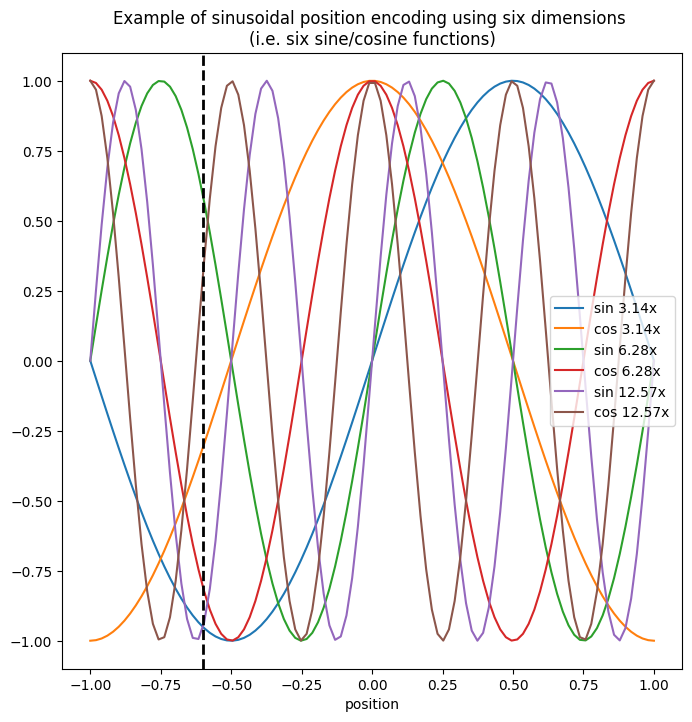

In [19]:
%matplotlib inline
plt.close()
pos_enc.plot(x='position', figsize=(8, 8))
plt.axvline(x=-0.6, c='black', linestyle='--', lw=2)
plt.title("Example of sinusoidal position encoding using six dimensions \n(i.e. six sine/cosine functions)");

In [20]:
class FCLayer(nn.Module):
    def __init__(self, dim_in, dim_out, activation = nn.ReLU(inplace=True)):
        super().__init__()
        self.layer = nn.Linear(dim_in, dim_out)
        self.activation = activation
        
    def forward(self, x):
        h = self.layer(x)
        if self.activation is not None:
            h = self.activation(h)
        return h

In [125]:
class SimpleNeRF(nn.Module):
    def __init__(self, coord_dims, direction_dims, normalize, n_layers, skip_at_layer, layer_dim = 256):
        super().__init__()
        self.layer_dim = layer_dim
        self.coord_dims = coord_dims
        self.coord_encoding = PositionalEncoding(coord_dims, 3, normalize=normalize)
        self.direction_dims = direction_dims
        self.dir_encoding = PositionalEncoding(direction_dims, 3, normalize=normalize)
        self.input_layer = FCLayer(6 * coord_dims, layer_dim)
        
        self.layers_pre_skip = nn.Sequential(*((FCLayer(layer_dim, layer_dim),) * (skip_at_layer - 1)))
        self.skip_layer = FCLayer(layer_dim + 6 * coord_dims, layer_dim)
        self.layers_post_skip = nn.Sequential(
            *((FCLayer(layer_dim, layer_dim),) * (n_layers - skip_at_layer - 3))
        )
        self.density_output = FCLayer(layer_dim, layer_dim + 1, activation=None)
        self.direction_fc = FCLayer(layer_dim + 6 * direction_dims, layer_dim // 2)
        self.rgb_output = FCLayer(layer_dim // 2, 3, activation=nn.Sigmoid())
        
    def forward(self, coords, dirs):
        # The test image produces 4D tensors:
        coords = coords.squeeze(0) if coords.dim() == 4 else coords
        dirs = dirs.squeeze(0) if dirs.dim() == 4 else dirs
        
        # coords, dirs = x.split(x.size(-1) // 2, dim=-1)
        B, N_pts, N_coords, N_dirs = coords.size(0), coords.size(-2), coords.size(-1), dirs.size(-1)        
        
        coords = self.coord_encoding(coords)
        assert coords.shape == (B, N_pts, 2 * self.coord_dims * N_coords)
        
        dirs = self.dir_encoding(dirs)
        assert dirs.shape == (B, N_pts, 2 * self.direction_dims * N_dirs)
        
        h = self.input_layer(coords); assert h.shape == (B, N_pts, self.layer_dim)
        h = self.layers_pre_skip(h); assert h.shape == (B, N_pts, self.layer_dim)
        
        h = torch.concat([h, coords], dim=-1)
        assert h.shape == (B, N_pts, self.layer_dim + 2 * self.coord_dims * N_coords)
        h = self.skip_layer(h)
        h = self.layers_post_skip(h)
        h = self.density_output(h); assert h.shape == (B, N_pts, self.layer_dim + 1)
        
        density, h = h.split([1, self.layer_dim], dim=-1)
        
        h = torch.concat([h, dirs], dim=-1)
        assert h.shape == (B, N_pts, self.layer_dim + 2 * self.direction_dims * N_dirs)
        
        h = self.direction_fc(h)

        return torch.relu(density), self.rgb_output(h)        
        

In [243]:
class SimpleNeRFModule(pl.LightningModule):
    def __init__(self, batch_size = 512, learning_rate = 3e-4, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.coarse_model = SimpleNeRF(
            coord_dims=self.hparams.coord_dims,
            direction_dims=self.hparams.direction_dims,
            normalize=self.hparams.normalize_position,
            n_layers=self.hparams.n_layers,
            skip_at_layer=self.hparams.skip_at_layer,
            layer_dim=self.hparams.layer_dim,
        )
        if self.hparams.use_fine_samples:
            self.fine_model = SimpleNeRF(
                coord_dims=self.hparams.coord_dims,
                direction_dims=self.hparams.direction_dims,
                normalize=self.hparams.normalize_position,
                n_layers=self.hparams.n_layers,
                skip_at_layer=self.hparams.skip_at_layer,
                layer_dim=self.hparams.layer_dim,
            )
            self.weights = None
            self.centres = None
        self.log_to_wanb = self.hparams.logging

    def forward(self, coords, dirs):
        if self.hparams.use_fine_samples:
            return self.coarse_model(coords, dirs), self.fine_model(coords, dirs)
        else:
            return self.coarse_model(coords, dirs)
    
    def loss_function(self, img_colours_coarse, y_c, img_colours_fine = None, y_f=None):
        if self.hparams.use_fine_samples:
            return F.mse_loss(img_colours_coarse, y_c).mean() + F.mse_loss(img_colours_fine, y_f).mean()
        else:
            return F.mse_loss(img_colours_coarse, y_c).mean()
    
    def training_step(self, batch, batch_idx):
        points_c, directions_c, distances_c, y_c, idxs_c = batch["coarse"]
        density_c, rgb_c = self.coarse_model(points_c, directions_c)
        img_cols_c, weights = render_image_colours(
            distances_c, directions_c, density_c, rgb_c, self.hparams.noise_std, self.hparams.normalize_directions
        )

        if self.hparams.use_fine_samples:
            points_f, directions_f, distances_f, y_f, _ = batch["fine"]
            density_f, rgb_f = self.fine_model(points_f, directions_f)
            img_cols_f, _ = render_image_colours(
                distances_f, directions_f, density_f, rgb_f, self.hparams.noise_std, self.hparams.normalize_directions
            )
            loss = self.loss_function(img_cols_c, y_c, img_cols_f, y_f)
        else:
            loss = self.loss_function(img_cols_c, y_c)
            
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=self.log_to_wanb)
        
        # We need to return the indexes of the sample rays seen in this step to know which positions
        # of the weights tensor to update when creating the new fine distribution's PDF.
        return {"loss": loss, "weights": weights, "bin_centres": distances_c, "indexes": idxs_c}
        
    def training_epoch_end(self, outputs):
        # After each epoch except the last, we update the distribution used for fine sampling to improve 
        # its representativity of the scene's areas of interest. We don't do this after the final epoch
        # because the model needs to perform inference using a point distribution it's been trained on.

        # Resample new points along the rays using the coarse uniform distribution
        self.trainset_c.update_ray_samples(True, None, None)

        if self.hparams.use_fine_samples:
            weights = torch.concat([out["weights"].cpu() for out in outputs], dim=0)
            centres = torch.concat([out["bin_centres"].cpu() for out in outputs], dim=0)
            indices = torch.concat([out["indexes"].cpu() for out in outputs], dim=0)
            # Put the rays in the same order as in the unshuffled dataset and add a slice of 
            # zeros to ensure size compatibility (this slice corresponds to the test image)
            pix_per_img = self.coarse_data_provider.h * self.coarse_data_provider.w
            self.weights = torch.concat(
                [
                    weights[indices],
                    torch.zeros((pix_per_img, weights.size(-2), weights.size(-1)))
                ], 
                dim=0
            )
            self.centres = torch.concat(
                [
                    centres[indices], 
                    centres[-pix_per_img :] + 0.1
                ], 
                dim=0
            )

            # Create the new fine distribution using the weights calculated this epoch
            self.distribution = PiecewiseConstant(
                self.weights / self.weights.sum(dim=-2, keepdims=True),
                self.centres,
                self.hparams.far_bound,
                validate_args=False
            )
            # Resample new points along the rays using the fine piecewise constant distribution
            self.trainset_f.update_ray_samples(True, #self.distribution, 
                                               None, self.hparams.fine_sample_multiplicator)
                
    # def on_predict_start(self):
    #     # Sample non-stochastic points along the rays (bin centres)
    #     self.testset_c.update_ray_samples(False, None, None)
            
    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        self.testset_c.update_ray_samples(False, None, None)
        
        if (not self.hparams.use_fine_samples) or (self.hparams.use_fine_samples and dataloader_idx == 0):
            points_c, directions_c, distances_c, _, idxs_c = batch
            points_c.squeeze_(0)
            directions_c.squeeze_(0)
            distances_c.squeeze_(0)
            density_c, rgb_c = self.coarse_model(points_c, directions_c)
            img_cols, img_weights = render_image_colours(
                distances_c, directions_c, density_c, rgb_c, 0., self.hparams.normalize_directions
            )

            if self.hparams.use_fine_samples:
                # Luckily we only execute this section once!
                self.weights[-img_weights.size(0) :] = img_weights  # replace placeholder zeros with image's weights
                self.centres[-distances_c.size(0) :] = distances_c  # replace placeholder zeros with image's bin centres
                # Create the new fine distribution using the weights calculated this epoch
                self.distribution = PiecewiseConstant(
                    self.weights / self.weights.sum(dim=-2, keepdims=True),
                    self.centres,
                    self.hparams.far_bound,
                    validate_args=False
                )
                # Resample new samples along the rays using the fine piecewise constant distribution
                self.testset_f.update_ray_samples(
                    False,
                    None, # self.distribution, 
                    self.hparams.fine_sample_multiplicator
                )
        
        if dataloader_idx == 1:
            points_f, directions_f, distances_f, _, _ = batch    
            points_f.squeeze_(0)
            directions_f.squeeze_(0)
            distances_f.squeeze_(0)
            density_f, rgb_f = self.fine_model(points_f, directions_f)
            img_cols, _ = render_image_colours(
                distances_f, directions_f, density_f, rgb_f, 0., self.hparams.normalize_directions
            )
            
        return img_cols
        
    def prepare_data(self):
        self.coarse_data_provider = RayDataProvider(
            np_data_filepath=self.hparams.np_data_filepath,
            n_samples_per_ray=self.hparams.n_samples_per_ray,
            near_bound=self.hparams.near_bound,
            far_bound=self.hparams.far_bound,
            initial_distribution=None,
            fine_sample_multiplicator=None,
            test_img_idx=None,
            random_state=self.hparams.random_state,
        )
        self.trainset_c = RayDataset(self.coarse_data_provider, train=True)
        self.testset_c = RayDataset(self.coarse_data_provider, train=False)
        
        if self.hparams.use_fine_samples:
            self.fine_data_provider = RayDataProvider(
                np_data_filepath=self.hparams.np_data_filepath,
                n_samples_per_ray=self.hparams.n_samples_per_ray,
                near_bound=self.hparams.near_bound,
                far_bound=self.hparams.far_bound,
                initial_distribution=None,
                fine_sample_multiplicator=self.hparams.fine_sample_multiplicator,
                test_img_idx=self.hparams.test_img_idx,
                random_state=self.hparams.random_state,
            )
            self.trainset_f = RayDataset(self.fine_data_provider, train=True)
            self.testset_f = RayDataset(self.fine_data_provider, train=False)
        
    def train_dataloader(self):
        if self.hparams.use_fine_samples:
            return {
                'coarse': DataLoader(
                    self.trainset_c, 
                    batch_size=self.hparams.batch_size, 
                    shuffle=True, 
                    num_workers=self.hparams.num_workers,
                ),
                'fine': DataLoader(
                    self.trainset_f, 
                    batch_size=self.hparams.batch_size, 
                    shuffle=True,
                    num_workers=self.hparams.num_workers,
                )
            }
        else:
            return {
                'coarse': DataLoader(
                    self.trainset_c, 
                    batch_size=self.hparams.batch_size, 
                    shuffle=True,
                    num_workers=self.hparams.num_workers,
                )
            }

    def predict_dataloader(self):
        if self.hparams.use_fine_samples:
            return [
                DataLoader(self.testset_c, batch_size=1, shuffle=False),
                DataLoader(self.testset_f, batch_size=1, shuffle=False),
            ]
        else:
            return [
                DataLoader(self.testset_c, batch_size=1, shuffle=False),
            ]
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.learning_rate)
        # scheduler = torch.optim.lr_scheduler.ExponentialLR(
        #     optimizer, gamma=0.1**(1/self.trainer.max_epochs)
        # )
        # return [optimizer], [scheduler]
        return optimizer

In [100]:
del origins
del dirs
del directions
del coords_all
del dist_all

NameError: name 'dirs' is not defined

In [244]:
torch.cuda.empty_cache()

## Training

In [245]:
import wandb
wandb.finish()

epoch,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆█████
lr-AdamW,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,█▁▁▁
train_loss_step,▄█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,4
lr-AdamW,0.0001
train_loss_epoch,0.14744
train_loss_step,0.13614
trainer/global_step,2359


In [249]:
pl.seed_everything(DATA_CONFIG['random_state'])
torch.cuda.empty_cache()

callbacks = [
    pl.callbacks.EarlyStopping(
        monitor="train_loss", 
        min_delta=RUN_CONFIG["early_stop_delta"],
        patience=RUN_CONFIG["early_stop_patience"]
    )
]

if RUN_CONFIG['logging']:
    logger = pl.loggers.WandbLogger(
        name=RUN_CONFIG["run_name"], project="NeRF", log_model=True, notes=RUN_CONFIG["run_notes"],
    )
    callbacks.append(pl.callbacks.LearningRateMonitor())

trainer = pl.Trainer(
    accelerator="gpu",
    callbacks=callbacks,
    reload_dataloaders_every_n_epochs=1,
    precision=16 if DATA_CONFIG["precision"] == torch.float16 else 32,
    max_epochs=RUN_CONFIG["max_epochs"],
    gradient_clip_val=RUN_CONFIG["gradient_clip_val"],
    logger=logger if RUN_CONFIG["logging"] else None,
    log_every_n_steps=RUN_CONFIG["log_every_n_steps"],
)

Global seed set to 42
d:\envs\fastai\lib\site-packages\pytorch_lightning\loggers\wandb.py:396: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [250]:
# model = SimpleNeRFModule(**RUN_CONFIG, **MODULE_CONFIG, **DATA_CONFIG)
trainer.fit(model)

d:\envs\fastai\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:604: UserWarning: Checkpoint directory .\NeRF\287l5lvu\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params
--------------------------------------------
0 | coarse_model | SimpleNeRF | 264 K 
1 | fine_model   | SimpleNeRF | 264 K 
--------------------------------------------
529 K     Trainable params
0         Non-trainable params
529 K     Total params
1.060     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


## Inference

In [34]:
# Uncomment if loading a previous checkpoint.
# model = SimpleNeRFModule.load_from_checkpoint('D:/experiments/NeRF/NeRF/25ucwktk/checkpoints/epoch=99-step=51300.ckpt')
# model.prepare_data()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 513it [00:00, ?it/s]

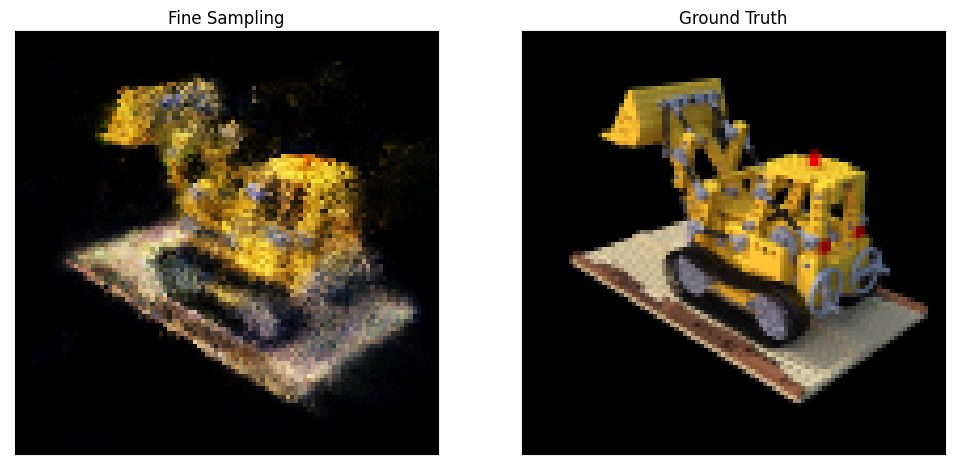

In [262]:
%matplotlib inline
img_cols_c = trainer.predict(model)
img_cols_c = img_cols_c[0]
if isinstance(img_cols_c , list):
    img_cols_c = img_cols_c[0]
# Normalise the images
img_cols_c = (img_cols_c - img_cols_c.amin(keepdim=True)) / (img_cols_c.amax(keepdim=True) - img_cols_c.amin(keepdim=True))

f = plt.figure(figsize=(12, 6))
ax1 = f.add_subplot(121)
ax1.set_title("Fine Sampling")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.imshow(img_cols_c.detach().reshape(100, 100, 3).numpy())

pixs = next(iter(trainer.predict_dataloaders[0]))[-2]
ax2 = f.add_subplot(122)
ax2.set_title("Ground Truth")
ax2.set_xticks([])
ax2.set_yticks([])
pixs = pixs.reshape(100, 100, 3).to(torch.float32).detach().numpy()
plt.imshow(pixs);

The model produces a recognisable image but the details are blurry and there are some artefacts. With more training epochs and a higher sampling density, this could probably be improved, but it then becomes quite slow to train on a consumer-grade GPU.